In [3]:
import numpy as np
import matplotlib.pyplot as plt

### Define the actual distribution parameters

In [4]:
n_dim = 3
mu_true = np.zeros(n_dim)
beta_true = np.diag([0.2,0.3,0.4])
print beta_true

[[0.2 0.  0. ]
 [0.  0.3 0. ]
 [0.  0.  0.4]]


In [5]:
def unnormalized_func(tetha,params):
    mu = params[0]
    beta = params[1]
    return np.exp(-0.5*np.dot((tetha-mu).T, np.dot(beta,tetha-mu)))

In [89]:
def MH_sampling(func, params,tetha0, n = 1000, lamda= 1):
    samples = [tetha0]
    cur_tetha = tetha0.copy()
    n_dim = len(tetha0)
    accept_num = 0
    for i in range(n):
        #print cur_tetha
        cur_func_value = func(cur_tetha,params)
        #Proposal distribution
        #new_tetha = cur_tetha + (np.random.rand(n_dim)-0.5)*lamda
        new_tetha = cur_tetha + (np.random.multivariate_normal(np.zeros(n_dim), np.eye(n_dim)))*lamda
        
        new_func_value = func(new_tetha,params)
        #decide whether to accept or reject
        accept_threshold = new_func_value/cur_func_value
        random_num = np.random.rand()
        if accept_threshold > 1 or random_num < accept_threshold:
            samples.append(new_tetha)
            cur_tetha = new_tetha
            accept_num += 1
        else:
            samples.append(cur_tetha)
    
    return np.array(samples), 1.0*accept_num/n

In [128]:
tetha0 = np.array([20,-40,30])
samples, acceptance_rate = MH_sampling(unnormalized_func, [mu_true,beta_true], tetha0, n = 5000,lamda = 1.5)
print 'Acceptance rate: ' + str(acceptance_rate)

Acceptance rate: 0.5254


In [129]:
def calc_autocorrelation(samples,d=1):
    mu = np.mean(samples)
    nom = 0
    n = len(samples)
    denom = np.var(samples)*n
    for i in range(n-d):
        nom += (samples[i]-mu)*(samples[i+d]-mu)
    return nom/denom

In [134]:
def statistics_1(samples):
    #calculate the sum for each of the sample
    new_samples = [np.sum(sample) for sample in samples]
    return new_samples

def statistics_2(samples):
    new_samples = [np.dot(sample, sample) for sample in samples]
    return new_samples

def statistics_4(samples):
    new_samples = [sample[0]**2 for sample in samples]
    return new_samples

def statistics_5(samples, i=0,j=1):
    new_samples = [sample[i]*sample[j] for sample in samples]
    return new_samples

def statistics_6(samples, i=0,j=1):
    mu = np.mean(samples)
    new_samples = [np.linalg.norm(sample-mu) for sample in samples]
    return new_samples


In [135]:
sample_statistic1 = statistics_1(samples)
sample_statistic2 = statistics_2(samples)
sample_statistic4 = statistics_4(samples)
sample_statistic5 = statistics_5(samples, 1, 2)
sample_statistic6 = statistics_6(samples)


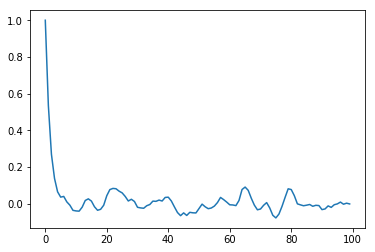

In [132]:
autocorrs = []
for d in range(0,500, 5):
    autocorrs.append(calc_autocorrelation(sample_statistic1,d))
plt.plot(autocorrs)

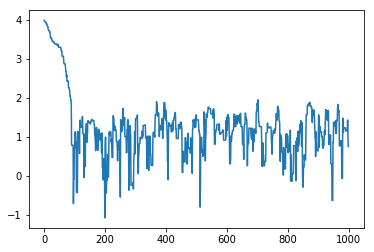

In [138]:
plt.plot(np.log(sample_statistic6[:1000]))